In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FunctionTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [43]:

# Step 1: Load the Data
data_url = 'climate_change_indicators.csv'
data = pd.read_csv(data_url)


In [94]:

# Step 2: Preprocess the Data
def preprocess_data(data):
    # Remove rows with more than 4 NaN or null values
    data = data.dropna(thresh=len(data.columns) - 4)

    # Melt the data after removing rows with excessive NaNs
    data_long = data.melt(id_vars=['ObjectId', 'Country', 'ISO2', 'ISO3', 'Indicator', 'Unit', 'Source', 'CTS_Code', 'CTS_Name', 'CTS_Full_Descriptor'], 
                          var_name='Year', 
                          value_name='Value')

    data_long['Year'] = data_long['Year'].str[1:].astype(int)
    data_long = data_long.dropna(subset=['Value'])
    data_selected = data_long[['ISO3', 'Indicator', 'Year', 'Value']]
    data_pivot = data_selected.pivot_table(index='Year', columns=['ISO3', 'Indicator'], values='Value')

    return data_pivot


In [95]:

data_pivot = preprocess_data(data)

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_pivot.fillna(0))
data_normalized = pd.DataFrame(data_normalized, index=data_pivot.index, columns=data_pivot.columns)


In [96]:

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i:i+sequence_length].values)
        targets.append(data.iloc[i+sequence_length].values)
    return np.array(sequences), np.array(targets)


In [97]:

sequence_length = 5
X, y = create_sequences(data_normalized, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [98]:

def create_model(units=50, dropout_rate=0.2, learning_rate=0.005):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model



In [99]:
# Custom transformer to reshape the input
def reshape_input(X):
    return X.reshape((X.shape[0], sequence_length, X.shape[1] // sequence_length))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Pipeline definition
pipeline = Pipeline([
    ('reshape', FunctionTransformer(reshape_input, validate=False)),
    ('model', KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping]))
])


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17168\4286398650.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('model', KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping]))


In [101]:
# Hyperparameter tuning
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2, 0.3, 0.5],
    'model__batch_size': [32, 64],
    'model__epochs': [50, 100]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train.reshape((X_train.shape[0], sequence_length * X_train.shape[2])), y_train)

best_model = grid_search.best_estimator_

# Print the chosen parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Predict on the test set
y_pred_test = best_model.predict(X_test.reshape((X_test.shape[0], sequence_length * X_test.shape[2])))

# Inverse transform the predictions
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_test_inverse = scaler.inverse_transform(y_pred_test)

# Compute metrics
mae = mean_absolute_error(y_test_inverse, y_pred_test_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_test_inverse)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE): 0.3643778856326285
# Mean Squared Error (MSE): 0.22370142694894696
# Root Mean Squared Error (RMSE): 0.47297085211347534

Best parameters found:
{'model__batch_size': 64, 'model__dropout_rate': 0.3, 'model__epochs': 50, 'model__units': 50}
Mean Absolute Error (MAE): 0.36442837485151636
Mean Squared Error (MSE): 0.2213642403140491
Root Mean Squared Error (RMSE): 0.4704936134678654


In [ ]:
# Step 7: Make Predictions for the Entire Timeline
X_all, y_all = create_sequences(data_normalized, sequence_length)
y_pred_all = best_model.predict(X_all.reshape((X_all.shape[0], sequence_length * X_all.shape[2])))

y_all_df = pd.DataFrame(y_all, columns=data_pivot.columns)
y_pred_all_df = pd.DataFrame(y_pred_all, columns=data_pivot.columns)

combined_all_pred = pd.concat([y_all_df, y_pred_all_df], axis=0)
combined_all_pred_inverse = scaler.inverse_transform(combined_all_pred)

y_all_inverse = combined_all_pred_inverse[:len(y_all)]
y_pred_all_inverse = combined_all_pred_inverse[len(y_all):]

years = data_pivot.index[-len(y_all):]

for i, country in enumerate(data_pivot.columns.levels[0]):
    for j, indicator in enumerate(data_pivot.columns.levels[1]):
        plt.figure(figsize=(12, 6))
        plt.plot(years, y_all_inverse[:, i*len(data_pivot.columns.levels[1]) + j], label='Actual', marker='o', alpha=0.7)
        plt.plot(years, y_pred_all_inverse[:, i*len(data_pivot.columns.levels[1]) + j], label='Predicted', marker='x', alpha=0.7)
        plt.title(f'{indicator} in {country}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Step 9: Predict Future Values
future_steps = 10
future_pred_normalized = np.copy(data_normalized.values[-sequence_length:])

for _ in range(future_steps):
    future_pred = best_model.predict(future_pred_normalized[-sequence_length:].reshape(1, sequence_length * future_pred_normalized.shape[1]))
    future_pred_normalized = np.vstack((future_pred_normalized, future_pred))

future_pred_combined = np.vstack((data_normalized.values, future_pred_normalized[-future_steps:]))
future_pred = scaler.inverse_transform(future_pred_combined)
future_pred = future_pred[-future_steps:, :]

future_years = range(2023, 2023 + future_steps)

for i, country in enumerate(data_pivot.columns.levels[0]):
    for j, indicator in enumerate(data_pivot.columns.levels[1]):
        plt.figure(figsize=(12, 6))
        plt.plot(future_years, future_pred[:, i*len(data_pivot.columns.levels[1]) + j], label='Predicted', marker='x', alpha=0.7)
        plt.title(f'Future {indicator} in {country}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

In [102]:
import geopandas as gpd

start_year = 2022
end_year = 2032
future_steps = end_year - start_year + 1

future_pred_normalized = np.copy(data_normalized.values[-sequence_length:])

for _ in range(future_steps):
    print(f"Predicting year {start_year + _}")
    future_pred = best_model.predict(future_pred_normalized[-sequence_length:].reshape(1, sequence_length * future_pred_normalized.shape[1]))
    future_pred_normalized = np.vstack((future_pred_normalized, future_pred))

print(future_pred_normalized.shape)

Predicting year 2022
Predicting year 2023
Predicting year 2024
Predicting year 2025
Predicting year 2026
Predicting year 2027
Predicting year 2028
Predicting year 2029
Predicting year 2030
Predicting year 2031
Predicting year 2032
(16, 175)


In [120]:

# Skalowanie wstecz wyników
future_pred_combined = np.vstack((data_normalized.values, future_pred_normalized[-future_steps:]))
future_pred = scaler.inverse_transform(future_pred_combined)
future_pred = future_pred[-future_steps:, :]

# Tworzenie DataFrame dla prognoz
future_years = range(start_year, start_year + future_steps)
future_pred_df = pd.DataFrame(future_pred, index=future_years, columns=data_pivot.columns)

# Wybór wskaźnika do wizualizacji (zmień na odpowiedni wskaźnik z Twojego zestawu danych)
indicator = 'Temperature change with respect to a baseline climatology'

# Ładowanie geodanych świata
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'), engine='pyogrio')

print(future_pred_df.columns)

future_pred_df.to_csv('future_pred.csv')

MultiIndex([('AFG', ...),
            ('AGO', ...),
            ('AIA', ...),
            ('ALB', ...),
            ('AND', ...),
            ('ARE', ...),
            ('ARG', ...),
            ('ASM', ...),
            ('ATG', ...),
            ('AUS', ...),
            ...
            ('VGB', ...),
            ('VIR', ...),
            ('VNM', ...),
            ('VUT', ...),
            ('WLD', ...),
            ('WLF', ...),
            ('WSM', ...),
            ('ZAF', ...),
            ('ZMB', ...),
            ('ZWE', ...)],
           names=['ISO3', 'Indicator'], length=175)


Visualizing year 2022


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


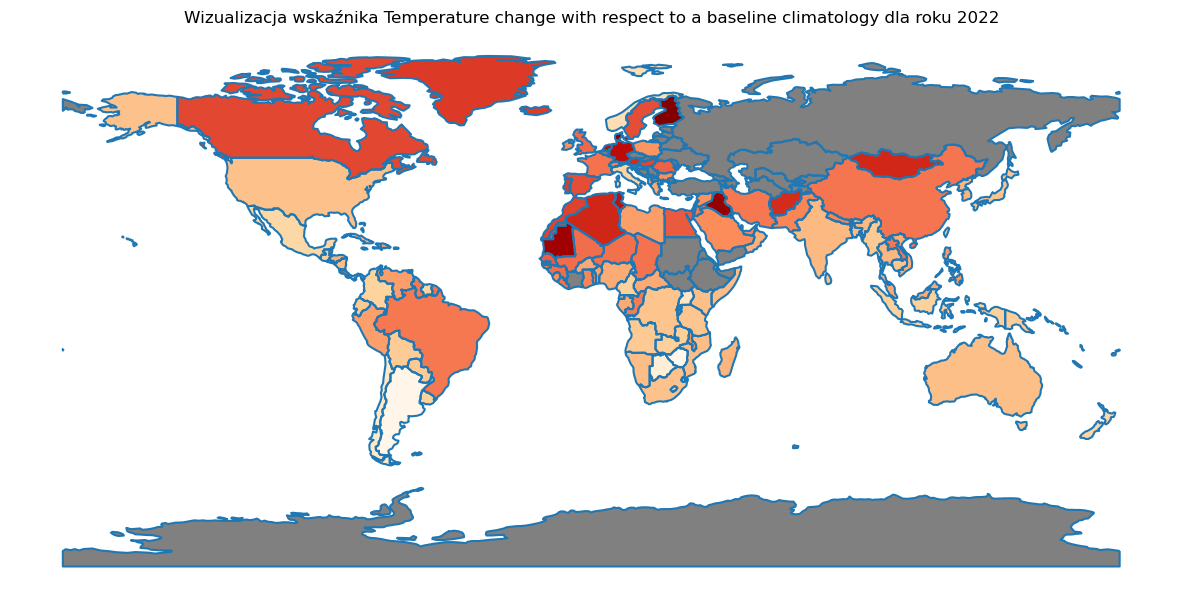

Visualizing year 2023


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


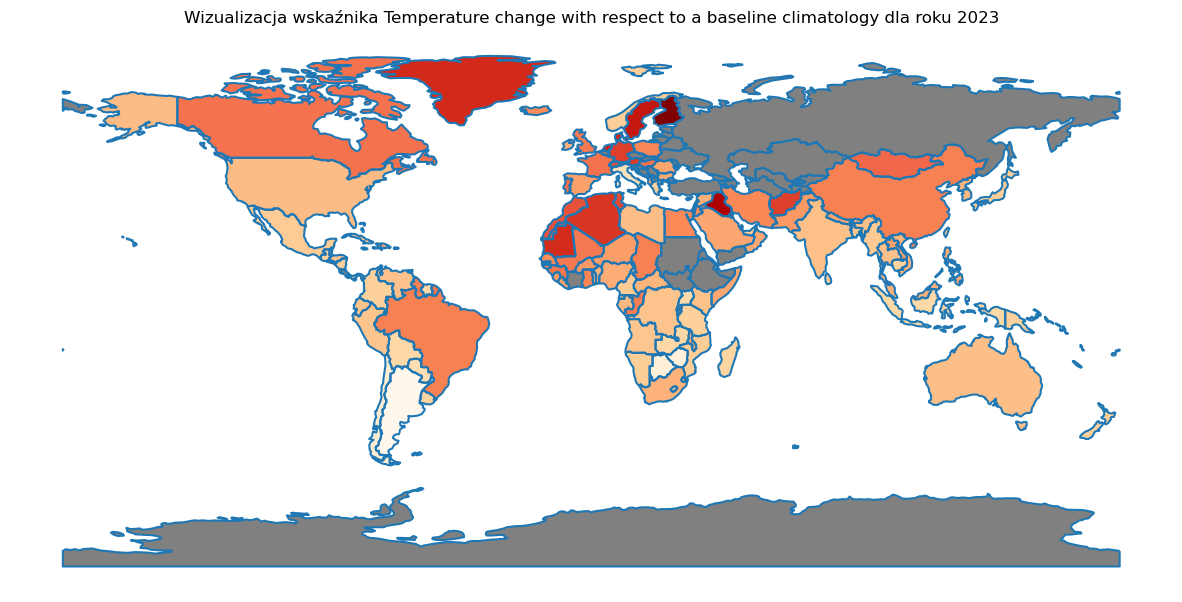

Visualizing year 2024


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


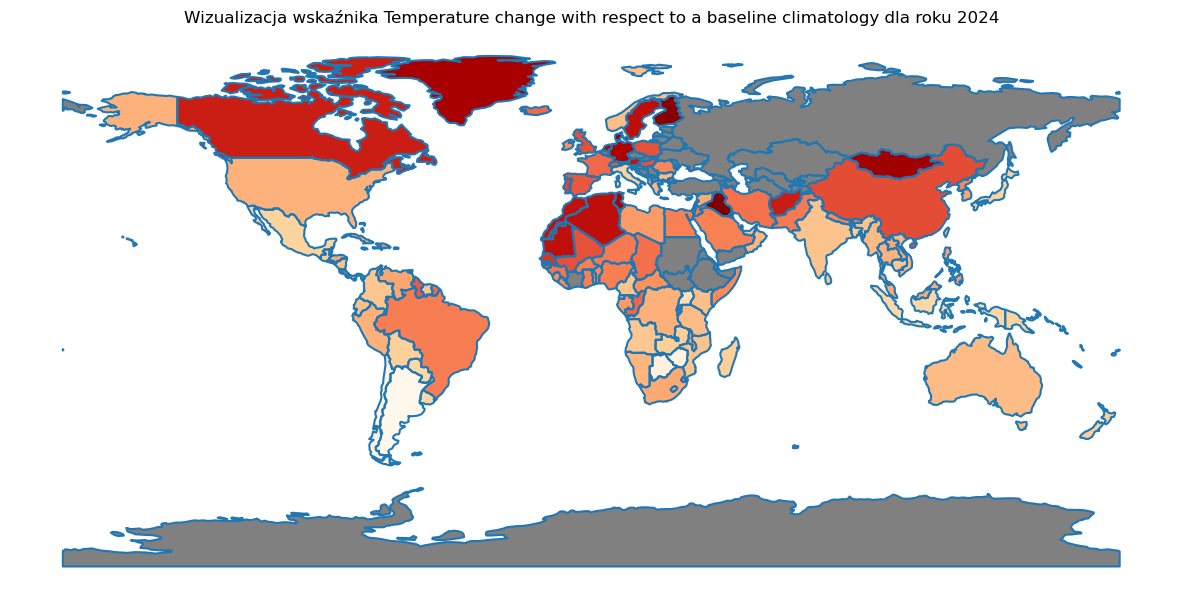

Visualizing year 2025


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


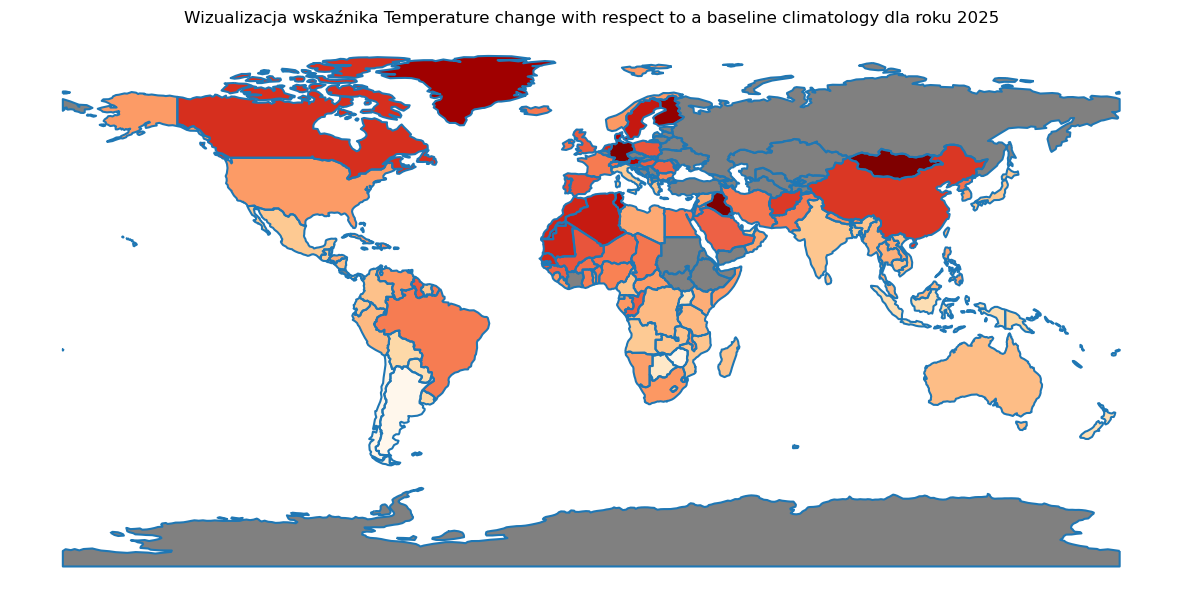

Visualizing year 2026


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


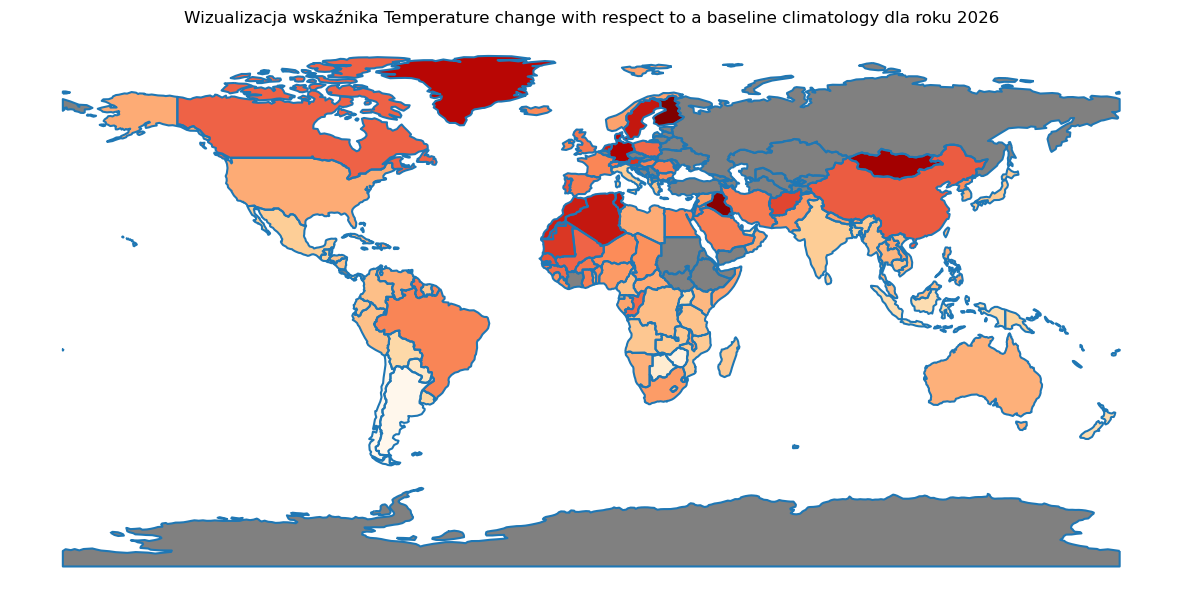

Visualizing year 2027


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


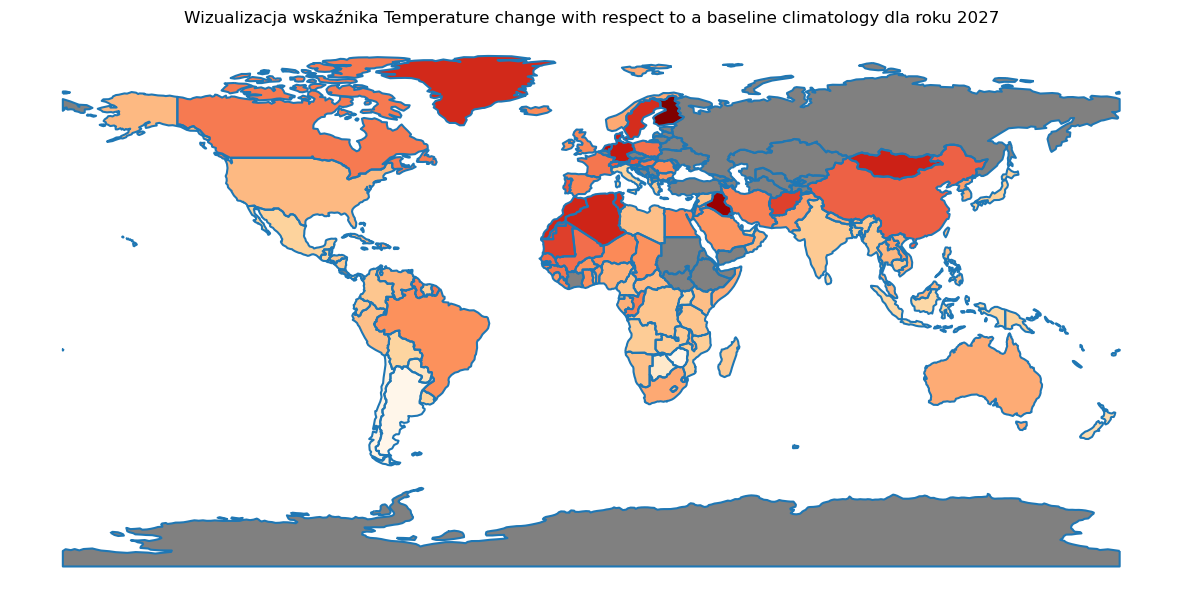

Visualizing year 2028


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


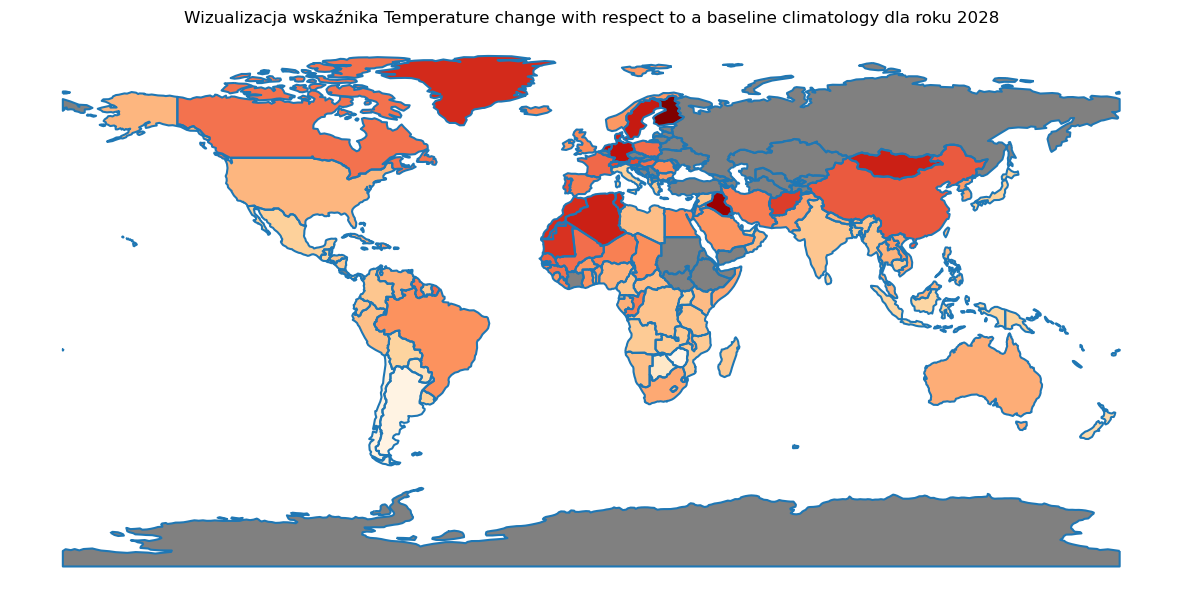

Visualizing year 2029


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


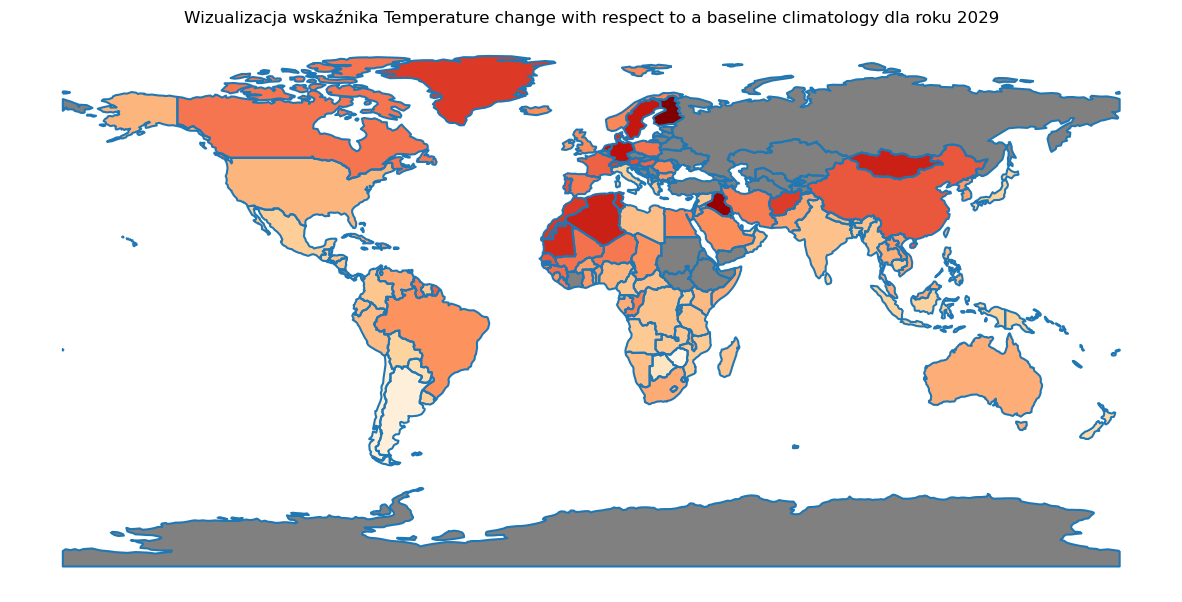

Visualizing year 2030


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


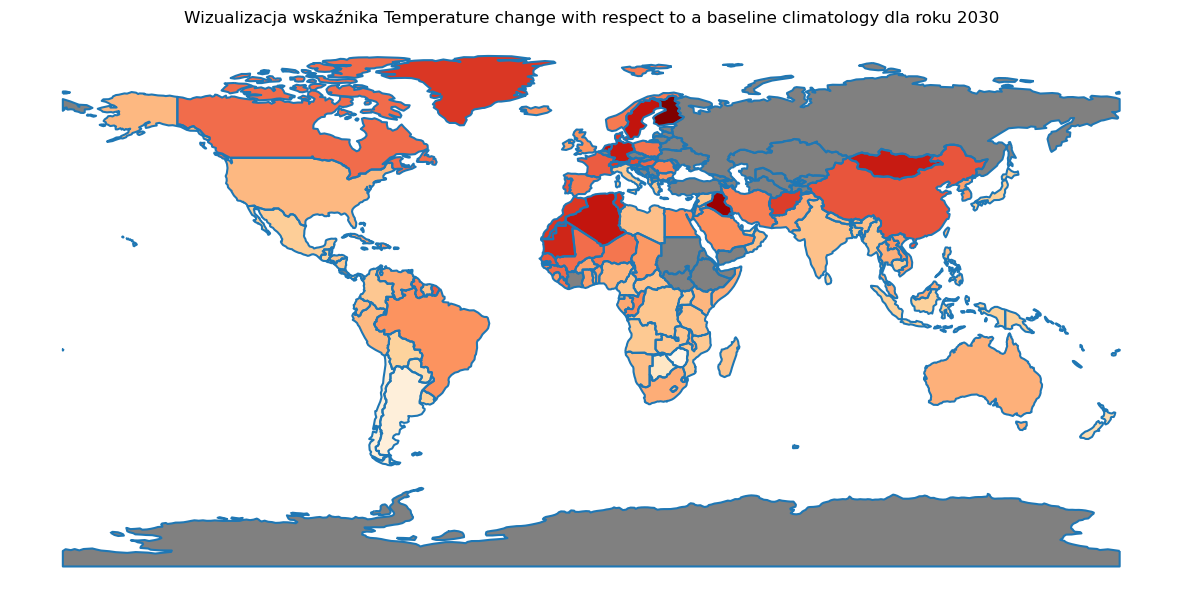

Visualizing year 2031


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


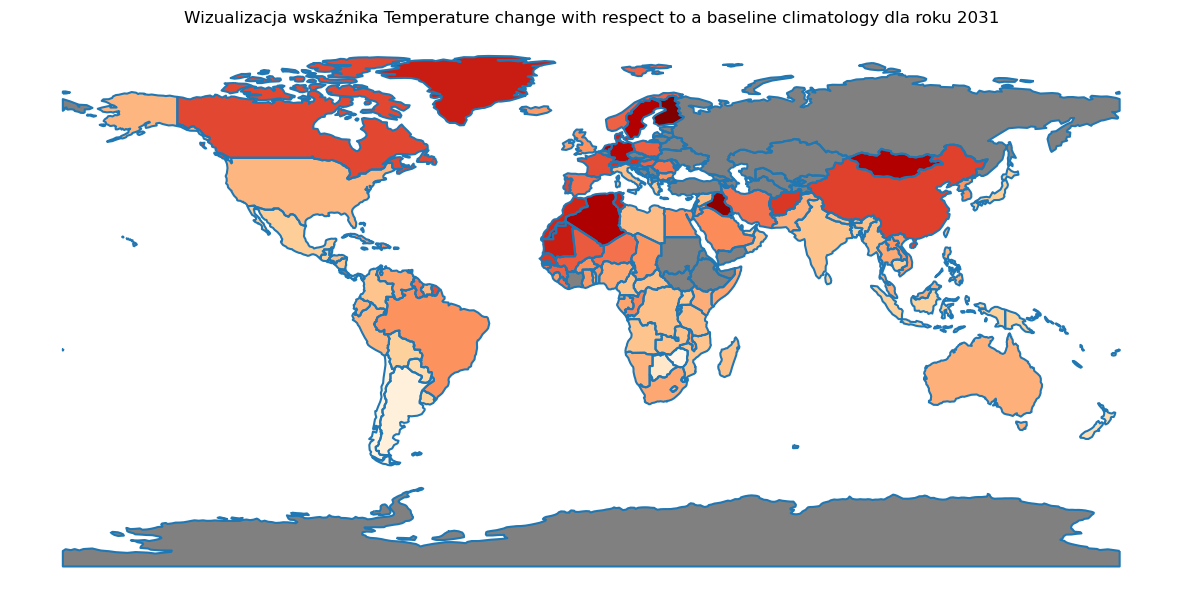

Visualizing year 2032


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


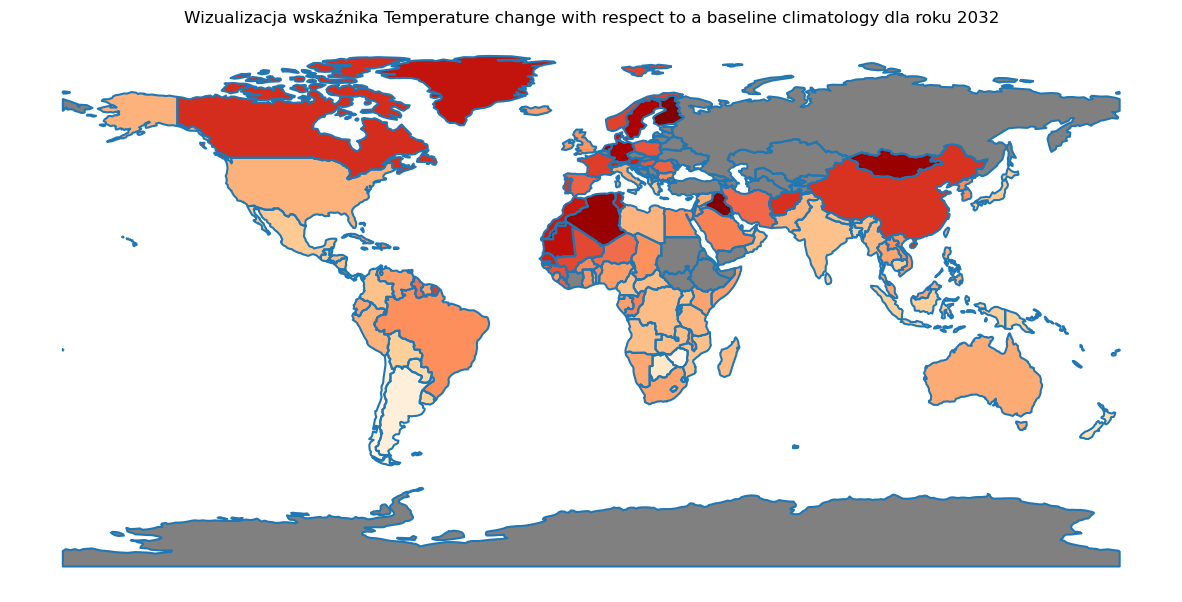

In [124]:
for year in future_years:
    print(f"Visualizing year {year}")
    
    # Dostęp do danych dla danego roku
    data_for_year = future_pred_df.loc[year].reset_index().rename(columns={year: 'Value', 'index': 'ISO3'})
    
    # Łączenie danych z geodanymi świata
    world_data = world.merge(data_for_year, left_on='iso_a3', right_on='ISO3', how='left')
    
    # Tworzenie mapy
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.boundary.plot(ax=ax)

    # Kraje bez danych (NaN) oznacz na szaro
    missing_data = world_data[world_data['Value'].isna()]
    missing_data.plot(ax=ax, color='grey')
    
    # Kraje z danymi
    world_data.plot(column='Value', ax=ax, legend=False,
                    legend_kwds={'label': f"Wartość wskaźnika: {indicator} w {year}",
                                 'orientation': "horizontal"},
                    cmap='OrRd')

    # Ustawienia wykresu
    ax.set_title(f"Wizualizacja wskaźnika {indicator} dla roku {year}")
    ax.set_axis_off()

    # Wyświetlenie mapy
    plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


Visualizing year 2022


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2022


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2023


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2024


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2025


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2026


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2027


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2028


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2029


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2030


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2031


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Visualizing year 2032


c:\Users\Lenovo\anaconda3\envs\tf2\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


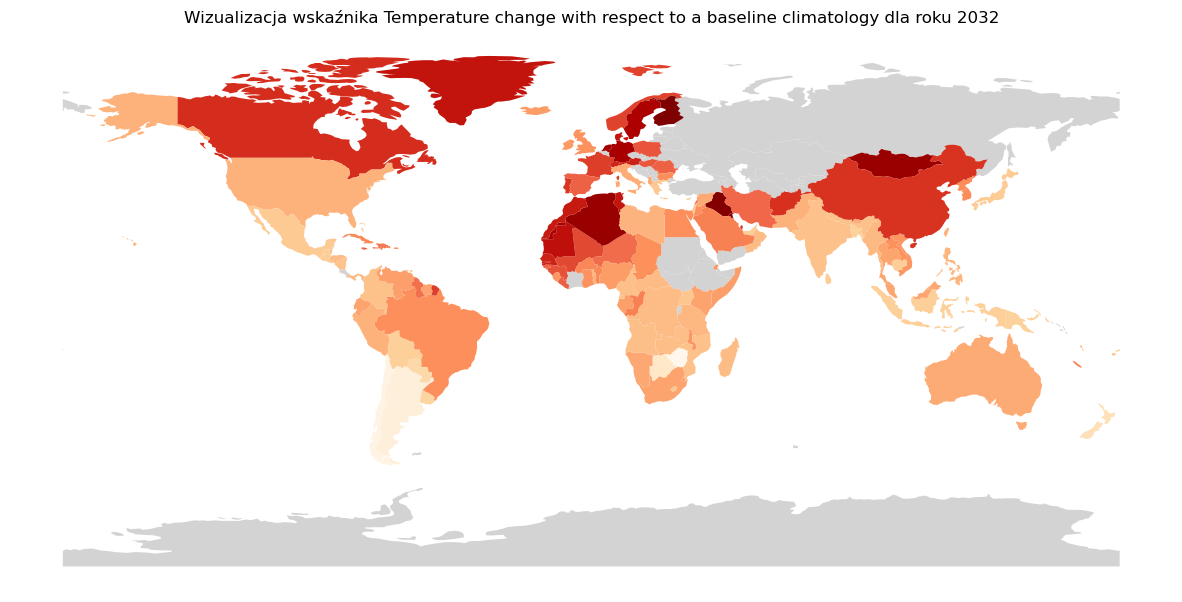

In [129]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)

# Funkcja animacji
def update(frame):
    ax.clear()
    year = future_years[frame]
    print(f"Visualizing year {year}")
    
    # Dostęp do danych dla danego roku
    data_for_year = future_pred_df.loc[year].reset_index().rename(columns={year: 'Value', 'index': 'ISO3'})
    
    # Łączenie danych z geodanymi świata
    world_data = world.merge(data_for_year, left_on='iso_a3', right_on='ISO3', how='left')
    
    # Kraje bez danych (NaN) oznacz na szaro
    missing_data = world_data[world_data['Value'].isna()]
    missing_data.plot(ax=ax, color='lightgrey')
    
    # Kraje z danymi
    world_data.plot(column='Value', ax=ax,
                    legend_kwds={'label': f"Wartość wskaźnika: {indicator} w {year}",
                                 'orientation': "horizontal"},
                    cmap='OrRd')

    # Ustawienia wykresu
    ax.set_title(f"Wizualizacja wskaźnika {indicator} dla roku {year}")
    ax.set_axis_off()

# Stwórz animację
ani = FuncAnimation(fig, update, frames=len(future_years), interval=1000, repeat=False)

# Zapisz animację do pliku mp4
ani.save('climate_change_animation.gif', writer='ffmpeg')

plt.show()

Data Pivot sample:
ISO3                                                                                                   AFG  \
Indicator Temperature change with respect to a baseline climatology, corresponding to the period 1951-1980   
Year                                                                                                         
1961                                                  -0.113                                                 
1962                                                  -0.164                                                 
1963                                                   0.847                                                 
1964                                                  -0.764                                                 
1965                                                  -0.244                                                 

ISO3                                                                                                

IndexError: list index out of range

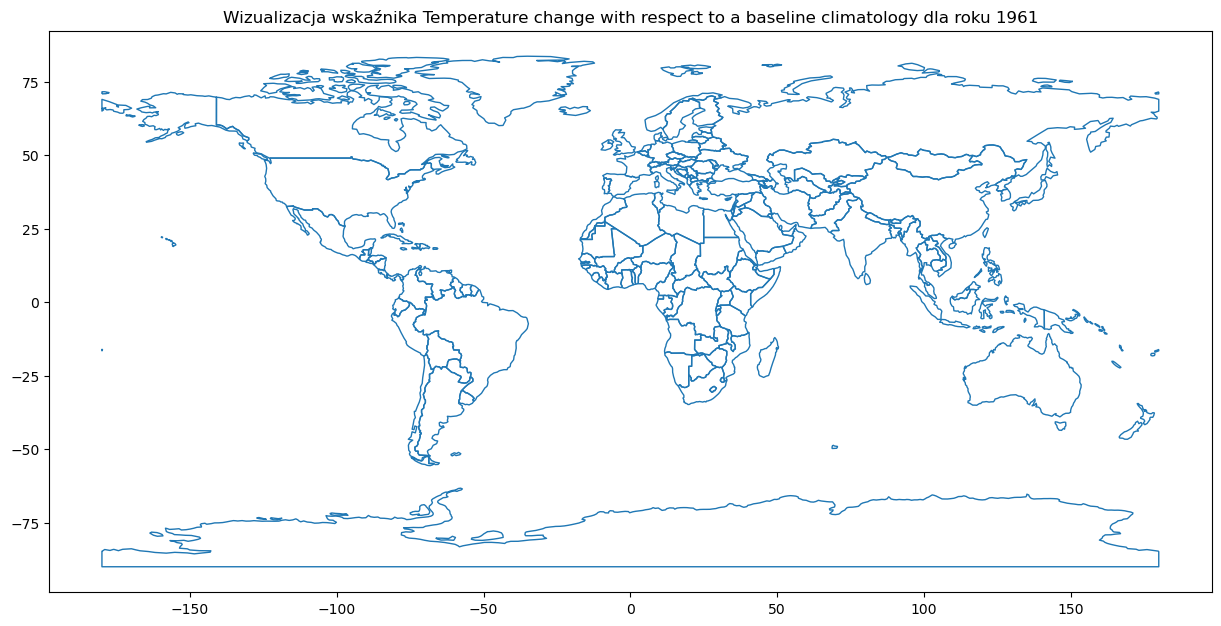

In [134]:
# Debugowanie: Wyświetlanie przykładowych danych
print("Data Pivot sample:")
print(data_pivot.head())

print("Future Prediction sample:")
print(future_pred_df.head())

# Połącz dane historyczne i prognozy
combined_df = pd.concat([data_pivot, future_pred_df])
combined_df = combined_df.reset_index(drop=True)

# Debugowanie: Wyświetlanie połączonych danych
print("Combined Data sample:")
print(combined_df.head())

# Sprawdź, czy kolumna 'Year' istnieje w połączonym DataFrame
if 'Year' not in combined_df.columns:
    print("Kolumna 'Year' nie została znaleziona w combined_df")
else:
    print("Kolumna 'Year' jest obecna w combined_df")

# Załaduj geodane świata
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'), engine = 'pyogrio')

# Wybór wskaźnika do wizualizacji (zmień na odpowiedni wskaźnik z Twojego zestawu danych)
indicator = 'Temperature change with respect to a baseline climatology'

# Zakres lat do wizualizacji
years = list(range(1961, 2033))

# Funkcja aktualizująca mapę dla każdego roku
def update(year):
    ax.clear()
    ax.set_title(f"Wizualizacja wskaźnika {indicator} dla roku {year}")
    world.boundary.plot(ax=ax, linewidth=1)
    
    # Dostęp do danych dla danego roku
    data_for_year = combined_df[combined_df['Year'] == year]
    world_data = world.merge(data_for_year, left_on='iso_a3', right_on='ISO3', how='left')
    
    # Oznacz kraje, dla których brakuje danych na szaro
    world_data['Value'] = world_data['Value'].fillna(-9999)
    world_data.plot(column='Value', ax=ax, legend=True, 
                    legend_kwds={'label': f"Wartość wskaźnika: {indicator} w {year}",
                                 'orientation': "horizontal"},
                    cmap='OrRd', missing_kwds={'color': 'lightgrey'})

# Tworzenie animacji
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ani = FuncAnimation(fig, update, frames=years, interval=1000, repeat=False)

# Zapisanie animacji jako GIF
ani.save('climate_change_animation.gif', writer='pillow')

plt.show()